In [1]:
%matplotlib inline
import os
import pathlib
import tensorflow as tf
import pathlib

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

In [2]:
# GPU 設定為 記憶體動態調整 (dynamic memory allocation)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
#  GPU 設定為固定為 2GB 
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*2)])


In [4]:
# 下載模型，並解壓縮
def download_model(model_name, model_date):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = model_name + '.tar.gz'
    # 解壓縮
    model_dir = tf.keras.utils.get_file(fname=model_name,
                                        origin=base_url + model_date + '/' + model_file,
                                        untar=True)
    return str(model_dir)

MODEL_DATE = '20200711'
MODEL_NAME = 'centernet_hg104_1024x1024_coco17_tpu-32'
PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)
PATH_TO_MODEL_DIR

'C:\\Users\\mikec\\.keras\\datasets\\centernet_hg104_1024x1024_coco17_tpu-32'

In [5]:
# 讀取 PATH_TO_MODEL_DIR 目錄下所有目錄及檔案
from os import listdir
from os.path import isfile, join
from os import path

for f in listdir(PATH_TO_MODEL_DIR):
    print(f)

checkpoint
pipeline.config
saved_model


In [6]:
# 下載 labels file
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)

LABEL_FILENAME = 'mscoco_label_map.pbtxt'
PATH_TO_LABELS = download_labels(LABEL_FILENAME)
PATH_TO_LABELS

'C:\\Users\\mikec\\.keras\\datasets\\mscoco_label_map.pbtxt'

Load the model
~~~~~~~~~~~~~~
Next we load the downloaded model



In [7]:
# 從下載的目錄載入模型，耗時甚久
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('載入模型...', end='')
start_time = time.time()

# 載入模型
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'共花費 {elapsed_time} 秒.')

Loading model...Done! Took 161.51106762886047 seconds


In [8]:
# 建立 Label 的對照表 (代碼與名稱)
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [26]:
# 選一張圖片(./images_2/image2.jpg)物件偵測
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 不顯示警告訊息
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

# 開啟一張圖片
image_np = np.array(Image.open('./images_2/image2.jpg'))

# 轉為 TensorFlow tensor 資料型態
input_tensor = tf.convert_to_tensor(image_np)
# 加一維，變為 (筆數, 寬, 高, 顏色)
input_tensor = input_tensor[tf.newaxis, ...]
# 這方法也可以
# input_tensor = np.expand_dims(image_np, 0)

detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))

# detections：物件資訊 內含 (候選框, 類別, 機率)
print(f'物件個數：{num_detections}')
detections = {key: value[0, :num_detections].numpy()
               for key, value in detections.items()}

detections['num_detections'] = num_detections
# 轉為整數
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

print(f'物件資訊 (候選框, 類別, 機率)：')
for detection_boxes, detection_classes, detection_scores in \
    zip(detections['detection_boxes'], detections['detection_classes'], detections['detection_scores']):
    print(np.around(detection_boxes,4), detection_classes, round(detection_scores*100, 2))
    
# import pandas as pd
# df = pd.DataFrame(detections)
# df

ValueError: `resize_images_and_return_shapes` expects a tf.float32 tensor

In [10]:
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False)

plt.figure(figsize=(12,8))
plt.imshow(image_np_with_detections, cmap='viridis')


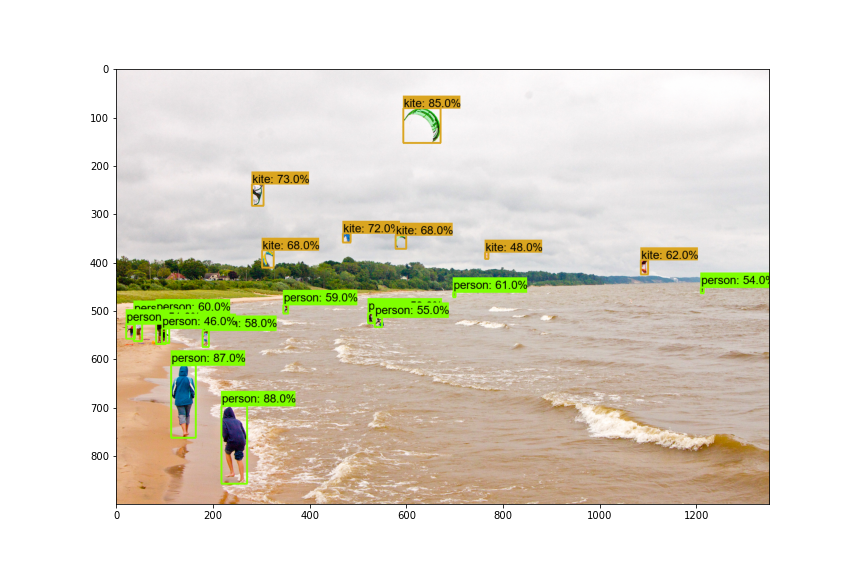

In [11]:
plt.savefig('./images_2/detection2.png')
# plt.show()
from IPython.display import Image
Image('./images_2/detection2.png')

In [16]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

PATH_TO_CFG = PATH_TO_MODEL_DIR + "/pipeline.config"
PATH_TO_CKPT = PATH_TO_MODEL_DIR + "/checkpoint"

print('Loading model... ', end='')
start_time = time.time()

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

# @tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model... Done! Took 0.6790368556976318 seconds


In [21]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

image_np = np.array(Image.open('./images_2/image2.jpg'))

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image_np, dtype=tf.float32)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

# input_tensor = np.expand_dims(image_np, 0)
detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))


print(f'物件個數：{num_detections}')
detections = {key: value[0, :num_detections].numpy()
               for key, value in detections.items()}
print(f'物件資訊 (候選框, 類別, 機率)：')
for detection_boxes, detection_classes, detection_scores in \
    zip(detections['detection_boxes'], detections['detection_classes'], detections['detection_scores']):
    print(np.around(detection_boxes,4), int(detection_classes)+1, round(detection_scores*100, 2))

detections['num_detections'] = num_detections
# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

物件個數：100
物件資訊 (候選框, 類別, 機率)：
[0.7752 0.1605 0.953  0.2007] 1 87.68
[0.6815 0.0841 0.8476 0.1226] 1 86.54
[0.0908 0.4389 0.1693 0.4965] 38 84.57
[0.2645 0.2077 0.3138 0.2261] 38 73.21
[0.3782 0.3465 0.3987 0.3593] 38 71.83
[0.3831 0.4269 0.4122 0.4442] 38 68.1
[0.4167 0.2228 0.4562 0.2414] 38 68.0
[0.5669 0.0273 0.6248 0.0404] 1 62.83
[0.439  0.8018 0.472  0.814 ] 38 62.12
[0.5143 0.5151 0.5238 0.52  ] 1 60.72
[0.5638 0.0611 0.6312 0.0765] 1 59.64
[0.5428 0.2553 0.5614 0.264 ] 1 59.3
[0.5617 0.3848 0.5844 0.3939] 1 58.54
[0.6015 0.1318 0.6387 0.1427] 1 57.79
[0.5719 0.3952 0.5924 0.4069] 1 55.13
[0.5027 0.8938 0.5147 0.8987] 1 54.25
[0.5873 0.0154 0.619  0.0291] 1 50.93
[0.4217 0.5643 0.4356 0.5697] 38 48.25
[0.5973 0.0701 0.6298 0.0818] 1 45.56
[5.660e-01 2.000e-04 5.797e-01 5.400e-03] 1 25.91
[0.5824 0.3836 0.5947 0.4006] 42 22.87
[0.572  0.037  0.5842 0.0439] 1 20.64
[0.5805 0.3937 0.5951 0.4089] 42 19.86
[0.5771 0.0456 0.5856 0.0506] 1 17.85
[0.5576 0.2545 0.5628 0.2643] 42 16.34
[0

In [24]:
# 將物件框起來
# min_score_thresh=.30 表機率(Confidence)至少要大於 30%
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes']+1,
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False)

plt.figure(figsize=(12,8))
plt.imshow(image_np_with_detections, cmap='viridis')
plt.show()

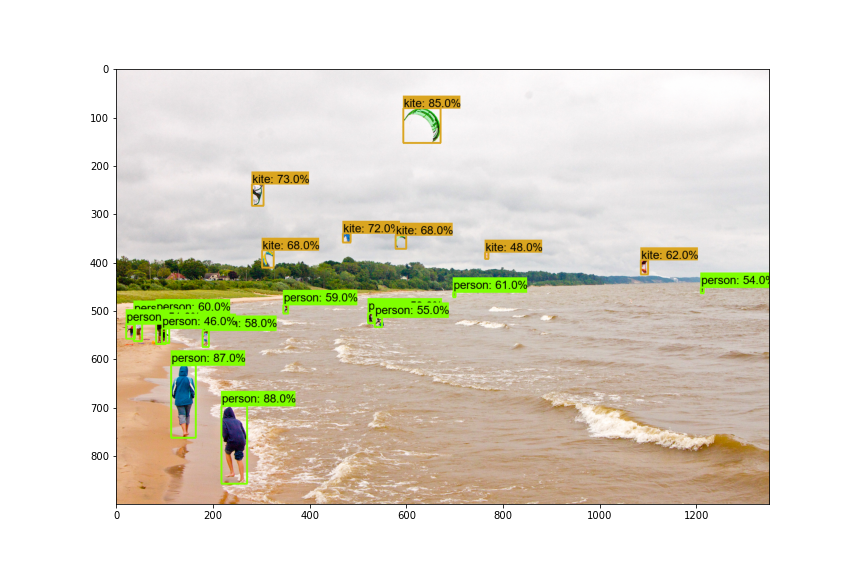

In [25]:
# 存檔
plt.savefig('./images_2/detection3.png')
# plt.show()
from IPython.display import Image
Image('./images_2/detection3.png')